In [1]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
import seaborn as sns
#import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
from matplotlib.mlab import griddata
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text,SelectMultiple,FloatRangeSlider
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from mpl_toolkits.mplot3d.axes3d import *
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from IPython.core.display import HTML,Image
from functools import reduce
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve,roc_auc_score,auc,precision_recall_curve,average_precision_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
cd /Users/james/NS_model

/Users/james/NS_model


In [3]:
# setup figure template
figure_template_path = 'bin/'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
# force reload of the module
reload(figure_template)
from figure_template import std_plot,display_dataframe, embed_pdf_figure, embed_pdf_pages
fontlegend = {'family':'Arial',
                  'weight' : 'normal', 
              #'linewidth':0.5,
                  'size' : 6.5*1}

In [4]:
FRB_H15_table = pd.read_table('data/FRB_H15.csv',sep=',',index_col=0).dropna()
frb_index = FRB_H15_table.index
time_arr = np.array([i.split('-') for i in frb_index[5:] ]).astype('int')

select_table = FRB_H15_table.iloc[np.concatenate((np.zeros([5]),(time_arr[:,0] >=2009)&(time_arr[:,2] ==6))).astype('bool')]
nan_ind = np.where(np.isin(np.array(FRB_H15_table.index),np.array(select_table.iloc[np.unique(np.where(select_table=='ND')[0])].index))==1)[0]

select_table.iloc[np.unique(np.where(select_table=='ND')[0])] = np.array(FRB_H15_table.iloc[nan_ind+1])


FRB_H15_table = pd.read_table('data/FRB_H15.csv',sep=',',index_col=0).dropna().iloc[:,:-1]
frb_index = FRB_H15_table.index
time_arr = np.array([i.split('-') for i in frb_index[5:] ]).astype('int')

select_table = FRB_H15_table.iloc[np.concatenate((np.zeros([5]),(time_arr[:,0] >=2002)&(time_arr[:,0] <=2010)&(time_arr[:,2] ==6))).astype('bool')]
nan_ind = np.where(np.isin(np.array(FRB_H15_table.index),np.array(select_table.iloc[np.unique(np.where(select_table=='ND')[0])].index))==1)[0]
if nan_ind.shape[0] >0:
    select_table.iloc[np.unique(np.where(select_table=='ND')[0])] = np.array(FRB_H15_table.iloc[nan_ind+1])



tmp = np.unique(time_arr[:,2],return_counts=1)[1]
plt.plot(tmp)
np.argmax(tmp)

In [5]:
select_table=select_table.astype('float')
revise_columns = np.array([i.split(' ')[7] for i in np.array(select_table.columns)]).astype('str')
select_table.columns = revise_columns
select_arr = np.array(select_table).astype('float')
month_ind = np.array([0,2,5,11,23,35,59,83,119,239,359])
resize_arr = np.zeros([select_arr.shape[0],360])
for i in range((select_arr.shape[0])):
    resize_arr[i] = np.interp(np.arange(360),month_ind,select_arr[i])

In [6]:
month_ind

array([  0,   2,   5,  11,  23,  35,  59,  83, 119, 239, 359])

In [7]:
select_arr[i]

array([2.43, 2.47, 2.53, 2.54, 2.52, 2.49, 2.49, 2.59, 2.69, 2.9 , 3.06])

In [8]:
month_ind

array([  0,   2,   5,  11,  23,  35,  59,  83, 119, 239, 359])

select_arr = np.array(select_table).astype('float')
month_ind = np.array([0,2,5,11,23,35,59,83,119,239])
resize_arr = np.zeros([select_arr.shape[0],240])
for i in range((select_arr.shape[0])):
    resize_arr[i] = np.interp(np.arange(240),month_ind,select_arr[i])

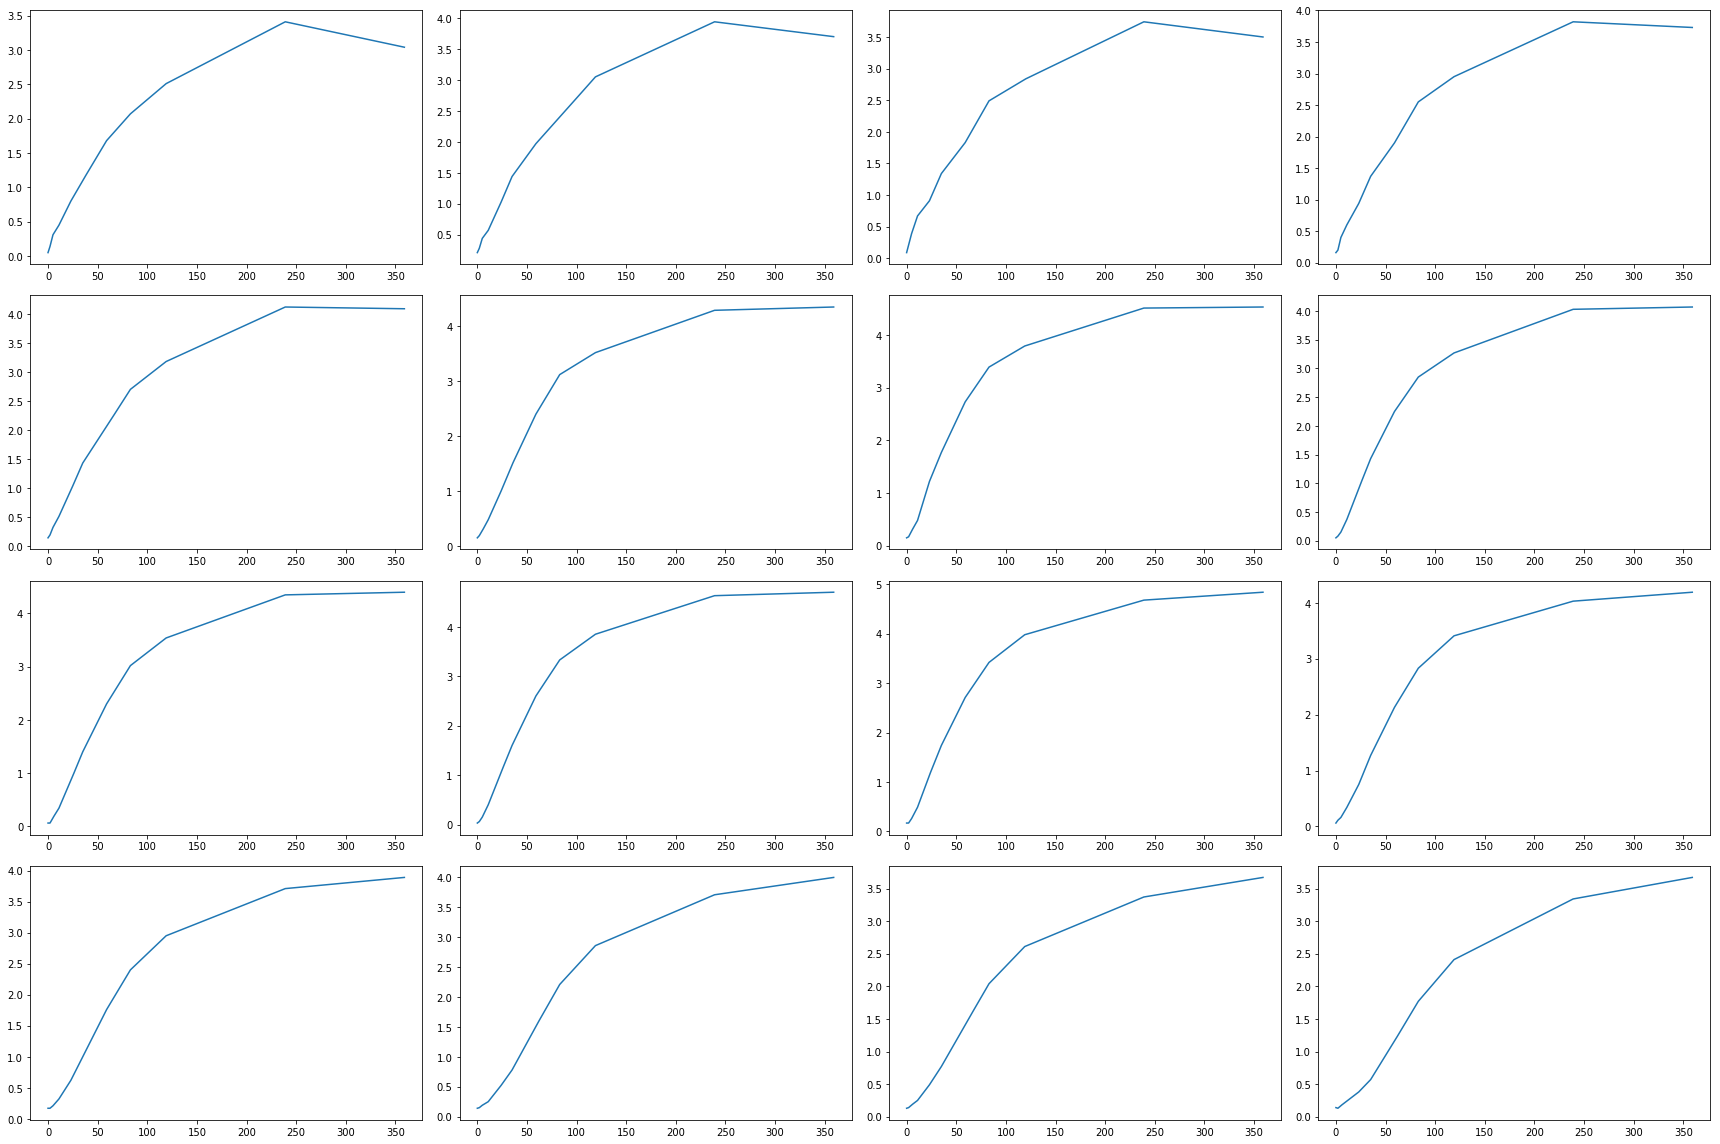

In [9]:
plot_num = 4
fig,ax = plt.subplots(plot_num,4,figsize=(24,4*plot_num))
for i in range(plot_num):
    for j in range(4):
        ax[i,j].plot(resize_arr[i*4+j])
fig.tight_layout()
#embed_pdf_figure()

In [10]:
time_start = 0
time_end = 89
start_point = 30
end_point = 240
Zs = resize_arr[time_start:time_end,start_point:end_point]
Zs = Zs.ravel()
Ys = np.repeat(np.arange(time_start,time_end),end_point-start_point)
Xs= np.repeat(np.arange(start_point,end_point),time_end-time_start).reshape(-1,time_end-time_start).T.ravel()


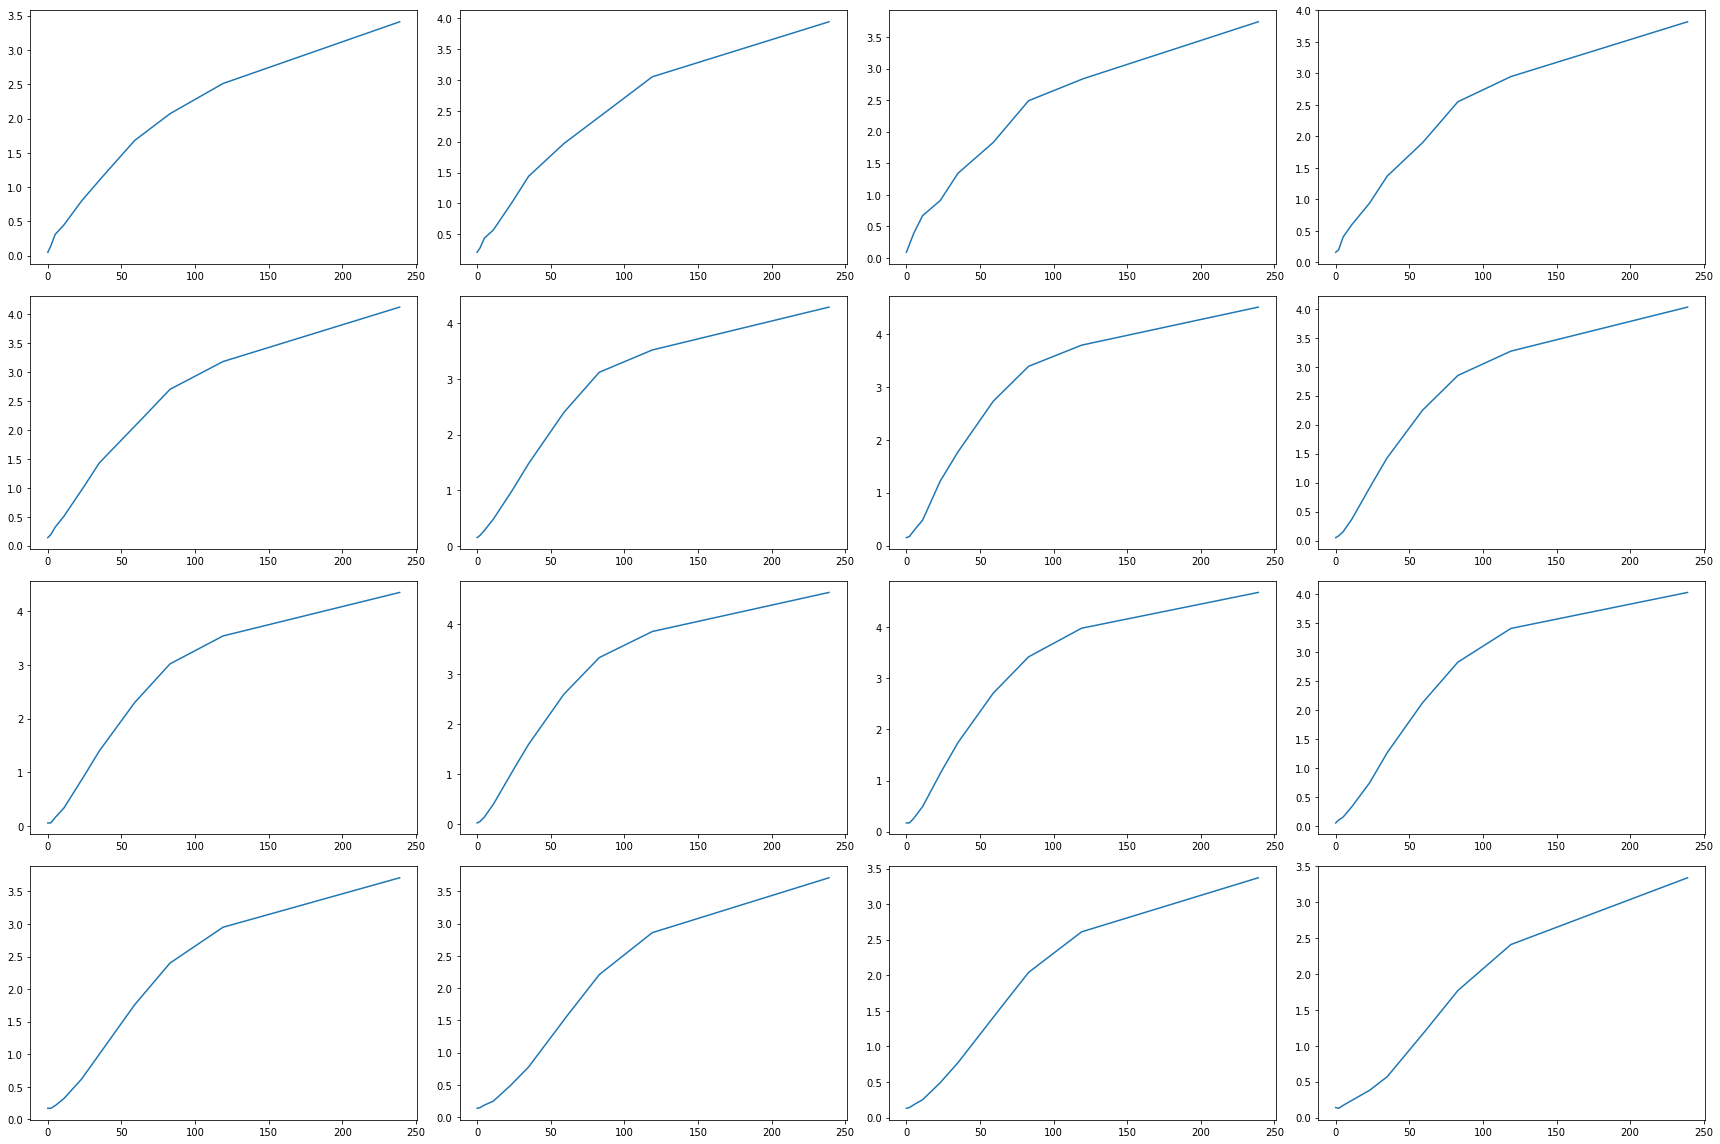

In [11]:
plot_num = 4
fig,ax = plt.subplots(plot_num,4,figsize=(24,4*plot_num))
for i in range(plot_num):
    for j in range(4):
        ax[i,j].plot(resize_arr[time_start:time_end,:end_point][i*4+j])
fig.tight_layout()
#embed_pdf_figure()

In [53]:
# creation of a 2D grid
def plot_3d_grid_surface(width,height,azim,elev,contextind,styind,featureind,savefig):
    fig = plt.figure(figsize=(width,height))
    X = Xs
    Y = Ys
    Z = Zs
    x = X.ravel()
    y = Y.ravel()
    z = Z.ravel()
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    Z = griddata(x, y, z, xi, yi,interp='linear')
    
    ax = plt.axes(projection='3d')
    #ax.scatter3D(x,y,z,c=z,cmap=plt.cm.jet)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=1, antialiased=True,alpha=1) 
    
    ax.contourf(X,Y,Z, zdir='z', offset=0, cmap=cm.coolwarm)
    
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)



    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(azim=azim,elev=elev)  # 50 20
    #ax.set_title('3D surface using feature '+'{:2}'.format(str(featureind)))
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax=std_plot(ax,'month','year','rate','3D plot',fontscale=4,
                xticklabel=np.array([str(i) for i in range(50,250,50)]),
               yticklabel = np.array([str(i) for i in range(2009,2019,2)]))
    fig.tight_layout()
    if savefig=='save':
        #fig.savefig('3D_surface_of_feature_'+'{:2}'.format(str(featureind)))
        fig.savefig('output/3D_surface.eps')
    else:
        plt.show()
interact(plot_3d_grid_surface,
    contextind=FloatSlider(min=0,max=3,step=1,value=2),
         styind=FloatSlider(min=0,max=2,step=1),
    width =FloatSlider(min=4,max=40,step=1,value=25),
         featureind=IntSlider(min=0,max=30,step=1,value=0),
    height= FloatSlider(min=4,max=30,step=1,value=16),
    azim= FloatSlider(min=0,max=180,step=2,value=45),
         savefig= RadioButtons(options=['show','save']),
    elev= FloatSlider(min=0,max=180,step=1,value=32))

interactive(children=(FloatSlider(value=25.0, description='width', max=40.0, min=4.0, step=1.0), FloatSlider(v…

<function __main__.plot_3d_grid_surface(width, height, azim, elev, contextind, styind, featureind, savefig)>

In [13]:
from matplotlib import animation
from IPython.display import HTML

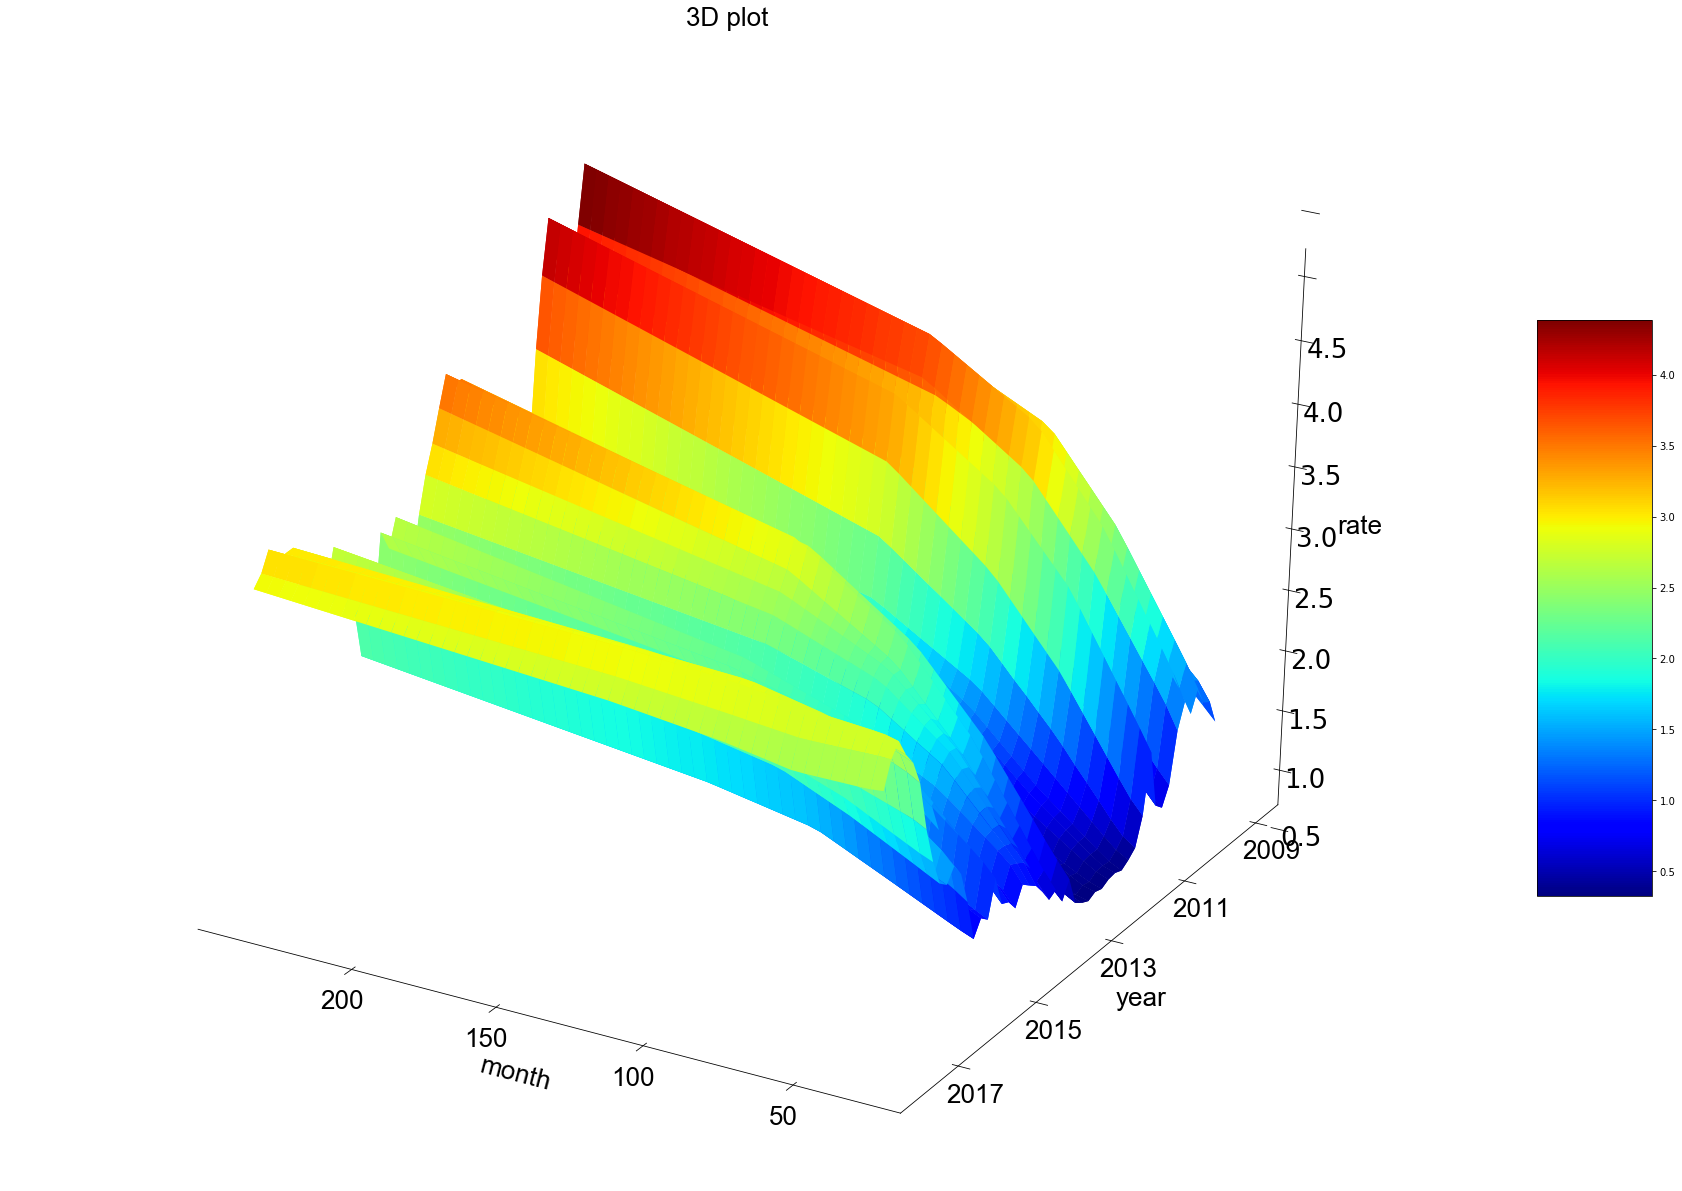

In [14]:
width=25
height=16

fig = plt.figure(figsize=(width,height))
ax = Axes3D(fig)
X = Xs
Y = Ys
Z = Zs
x = X.ravel()
y = Y.ravel()
z = Z.ravel()
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata(x, y, z, xi, yi,interp='linear')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=1, antialiased=True,alpha=1) 
fig.colorbar(surf, shrink=0.5, aspect=5)
#fig.tight_layout()

def init():
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet',linewidth=1, antialiased=True,alpha=1) 

    return fig,

def animate(i):
    ax.view_init(elev=32, azim=i)
    return fig,

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.invert_xaxis()
ax.invert_yaxis()
ax=std_plot(ax,'month','year','rate','3D plot',fontscale=4,
                xticklabel=np.array([str(i) for i in range(50,250,50)]),
               yticklabel = np.array([str(i) for i in range(2009,2019,2)]))

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=180,interval=20, blit=True)


(-2, 1.01)

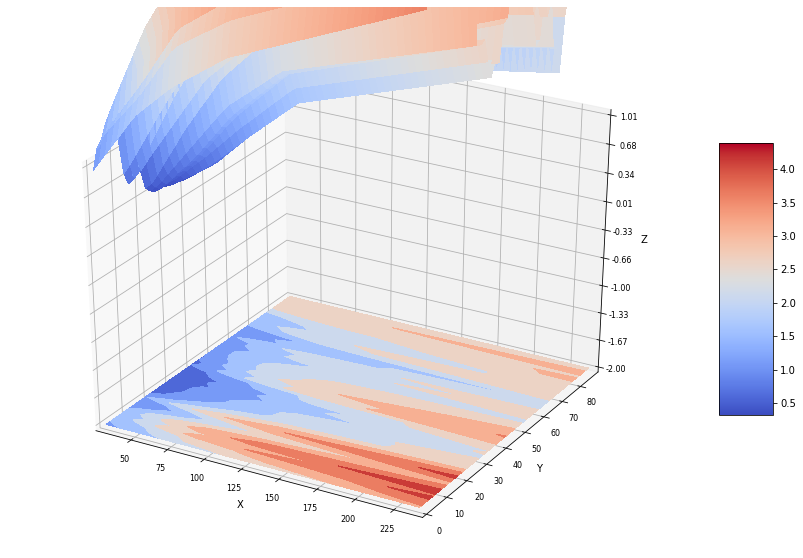

In [51]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


p = 0.05
f = -0.01

def get_data(p):
    X = Xs
    Y = Ys
    Z = Zs
    x = X.ravel()
    y = Y.ravel()
    z = Z.ravel()
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    Z = griddata(x, y, z, xi, yi,interp='linear')

    return X,Y,Z

x, y, z = get_data(p)

x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
z_min, z_max = np.min(z), np.max(z)

fig= plt.figure(figsize=(15, 10))


ax = plt.axes(projection='3d')
ax.tick_params(labelsize=8)
#ax.view_init(azim=azim, elev=elev)
#ax.plot_surface(x, y, z, rstride=10, cstride=10, alpha=1)
ax.contourf(x, y, z, zdir='z', offset=-2, cmap=cm.coolwarm)

surf = ax.plot_surface(x,y,z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)


ax.set_xlabel('X')
ax.set_xlim(x_min, x_max)
ax.set_ylabel('Y')
ax.set_ylim(y_min, y_max)
ax.set_zlabel('Z')
ax.set_zlim(-2, 1.01)



anim.save('basic_animation1.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

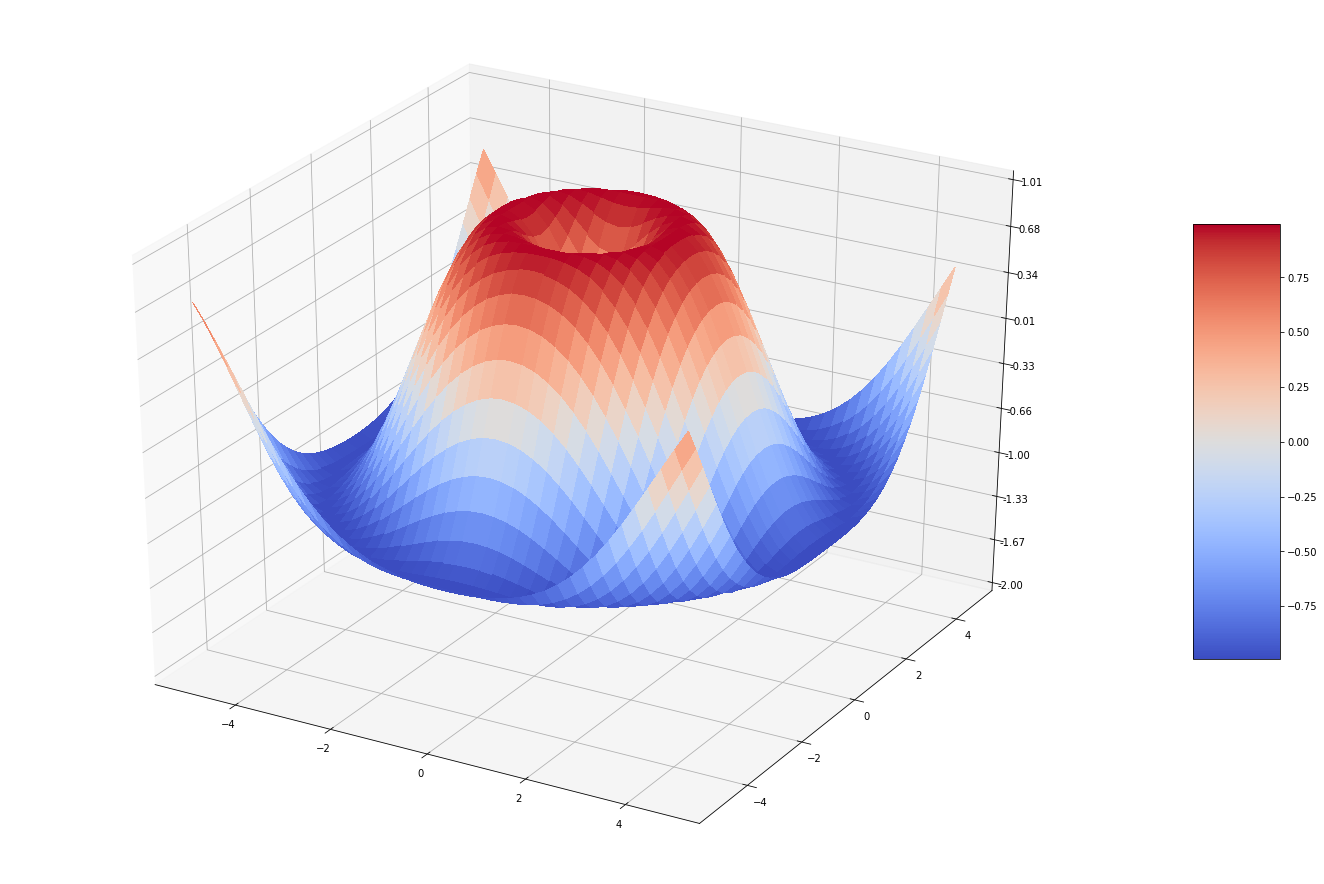

In [44]:
width=25
height=16

fig = plt.figure(figsize=(width,height))
#ax = Axes3D(fig)
ax = plt.axes(projection='3d')
# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-2, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.contourf(Z,Y,Z, zdir='z', offset=z_min, cmap=cm.coolwarm)
#ax.contourf(x, y, z, zdir='z', offset=z_min, cmap=cm.coolwarm)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [23]:
Z

array([[ 0.70886129,  0.57562789,  0.42921793, ...,  0.27541086,
         0.42921793,  0.57562789],
       [ 0.57562789,  0.4208019 ,  0.2570234 , ...,  0.09046523,
         0.2570234 ,  0.4208019 ],
       [ 0.42921793,  0.2570234 ,  0.08068791, ..., -0.09334004,
         0.08068791,  0.2570234 ],
       ...,
       [ 0.27541086,  0.09046523, -0.09334004, ..., -0.26940744,
        -0.09334004,  0.09046523],
       [ 0.42921793,  0.2570234 ,  0.08068791, ..., -0.09334004,
         0.08068791,  0.2570234 ],
       [ 0.57562789,  0.4208019 ,  0.2570234 , ...,  0.09046523,
         0.2570234 ,  0.4208019 ]])

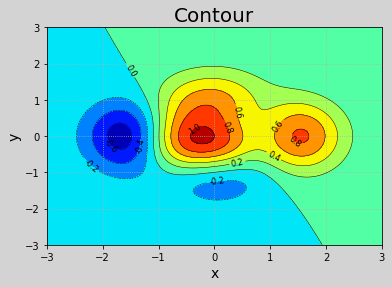

In [24]:
n = 1000  # 做1000*1000的点阵


x, y = np.meshgrid(np.linspace(-3, 3, n), np.linspace(-3, 3, n))
z = (1 - x / 2 + x**5 + y**3) * np.exp(-x**2 - y**2)


plt.figure('Contour', facecolor='lightgray')
plt.title('Contour', fontsize=20)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')

# 填充等高线图
plt.contourf(x, y, z, 8, cmap='jet')
# 绘制等高线
cntr = plt.contour(x, y, z, 8, colors='black',linewidths=0.5)
# 标注等高线
plt.clabel(cntr, inline_spacing=1, fmt='%.1f', fontsize=8)

plt.show()

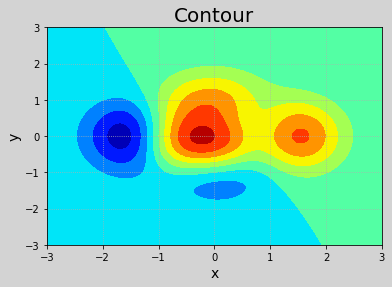

In [27]:
n = 1000  # 做1000*1000的点阵


x, y = np.meshgrid(np.linspace(-3, 3, n), np.linspace(-3, 3, n))
z = (1 - x / 2 + x**5 + y**3) * np.exp(-x**2 - y**2)


plt.figure('Contour', facecolor='lightgray')
plt.title('Contour', fontsize=20)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.tick_params(labelsize=10)
plt.grid(linestyle=':')

# 填充等高线图
plt.contourf(x, y, z, 8, cmap='jet')

plt.show()

(-2, 1.01)

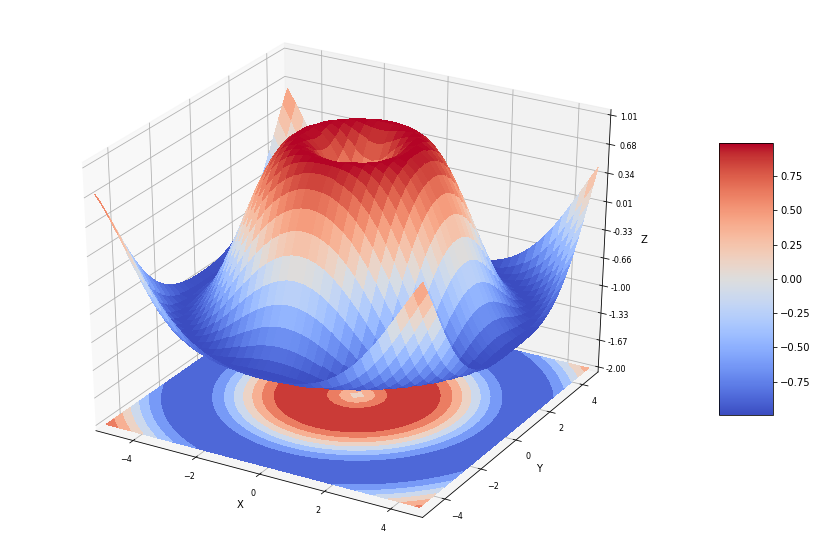

In [50]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

file_path = "./3D_surface_and_contour.jpg"
p = 0.05
f = -0.01

def get_data(p):
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)

    return X,Y,Z

x, y, z = get_data(p)

x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
z_min, z_max = np.min(z), np.max(z)

fig= plt.figure(figsize=(15, 10))


ax = plt.axes(projection='3d')
ax.tick_params(labelsize=8)
#ax.view_init(azim=azim, elev=elev)
#ax.plot_surface(x, y, z, rstride=10, cstride=10, alpha=1)
ax.contourf(x, y, z, zdir='z', offset=-2, cmap=cm.coolwarm)

surf = ax.plot_surface(x,y,z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)


ax.set_xlabel('X')
ax.set_xlim(x_min, x_max)
ax.set_ylabel('Y')
ax.set_ylim(y_min, y_max)
ax.set_zlabel('Z')
ax.set_zlim(-2, 1.01)

